In [60]:
import numpy as np
import matplotlib.pyplot as plt
from OmniCalibrator.OmniCalibrator import OmniCalibrator, HexagonalArray
%matplotlib notebook 

# Omnical Settings, Setup, and Simulation

In [61]:
#SETTINGS
np.random.seed(1)
noiseLevel = 0.1
gainLevel = .5 #exponential amplitude std
delayErrorLevel = 1.0 #in ns
nchan = 20
separation = 14.7
hexNum = 3
verbose = False
guessGainsCorrect = True

#Create array and channel independent quantities
ha = HexagonalArray(separation, hexNum, verbose=False)
ha.CalculateUBLs()
freqs = .1 + .1*np.arange(nchan)/nchan #in GHz
delayErrors = delayErrorLevel*np.random.randn(ha.nant) #in ns
gainAmplitudes = np.exp(gainLevel*np.random.randn(ha.nant))
overallVis = 1.0*(np.random.randn(ha.nubl) + 1.0j*np.random.randn(ha.nubl))

#Create observation
allGains, allTrueVis, allObsVis = [], [], []
allGuessGains, allGuessVis = [], []
for chan in range(nchan):
    #Gains
    gains = gainAmplitudes * np.exp(2.0j*np.pi*delayErrors*(freqs[chan]))
    guessGains = np.ones_like(gains)
    if guessGainsCorrect: guessGains = gains
    allGains.append(gains); allGuessGains.append(guessGains)
    
    #Visibilities
    trueVis = overallVis.copy()
    guessVis = np.ones_like(trueVis) 
    #guessVis = overallVis.copy()
    allTrueVis.append(trueVis); allGuessVis.append(guessVis)
    
    #Simulate Observations
    noiselessVis = np.array([gains[ant1] * np.conj(gains[ant2]) * trueVis[ha.indices2ublIndex[(ant1,ant2)]] for (ant1,ant2) in ha.blIndexPairs])
    noise = noiseLevel*(np.random.randn(ha.nbl) + 1.0j*np.random.randn(ha.nbl))
    obsVis = np.array(noiselessVis) + noise
    allObsVis.append(obsVis)
    
cal = OmniCalibrator(ha, verbose=verbose)

With 19 antennas there are 30 unique baselines.


# Run OmniCalibrator

In [62]:
allGainSols, allVisSols = [], []
for chan in range(nchan):
    obsVis, guessGains = allObsVis[chan], allGuessGains[chan]
    
    if chan==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains)        
    else: gainStart, visStart = allGainSols[chan-1], allVisSols[chan-1]
    gainSols, visSols = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, realImagMode=True, maxIter=100)
    allGainSols.append(gainSols); allVisSols.append(visSols)
    
allGainSols, allVisSols = cal.OverallBandpassDegeneracyProjection(allGainSols, allVisSols, allGuessGains)


# Plot Results

<IPython.core.display.Javascript object>


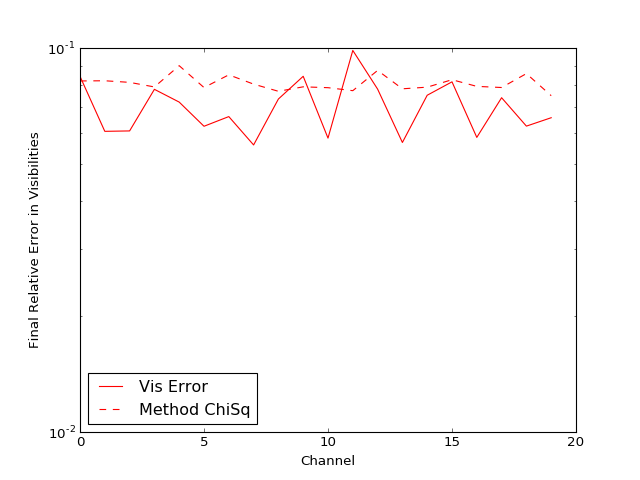

In [63]:
plt.figure()
plt.semilogy(range(nchan), [np.linalg.norm(visSols-trueVis) / np.linalg.norm(trueVis) for visSols,trueVis in zip(allVisSols, allTrueVis)],'r')
plt.semilogy(range(nchan), [np.linalg.norm(cal.ComputeErrors(allObsVis[chan], allGainSols[chan], allVisSols[chan])) / np.linalg.norm(allObsVis[chan]) for chan in range(nchan)],'r--')

plt.legend(['Vis Error', 'Method ChiSq'], loc=0)
plt.xlabel('Channel'); plt.ylabel('Final Relative Error in Visibilities');

<IPython.core.display.Javascript object>


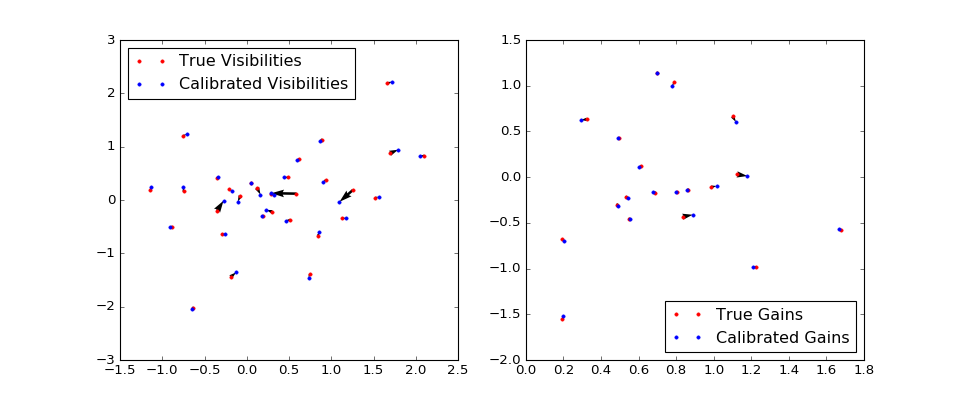

In [64]:
chan = 0
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.quiver(np.real(allTrueVis[chan]), np.imag(allTrueVis[chan]), np.real(allVisSols[chan]-allTrueVis[chan]), 
           np.imag(allVisSols[chan]-allTrueVis[chan]), angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(allTrueVis[chan]), np.imag(allTrueVis[chan]),'r.',label='True Visibilities')
plt.plot(np.real(allVisSols[chan]), np.imag(allVisSols[chan]),'b.',label='Calibrated Visibilities')
plt.legend(loc='best')

plt.subplot(122)
plt.quiver(np.real(allGains[chan]), np.imag(allGains[chan]), np.real(allGainSols[chan]-allGains[chan]), 
           np.imag(allGainSols[chan]-allGains[chan]), angles='xy', scale_units='xy', scale=1)
plt.plot(np.real(allGains[chan]), np.imag(allGains[chan]),'r.',label='True Gains')
plt.plot(np.real(allGainSols[chan]), np.imag(allGainSols[chan]),'b.',label='Calibrated Gains')
plt.legend(loc='best')


<IPython.core.display.Javascript object>


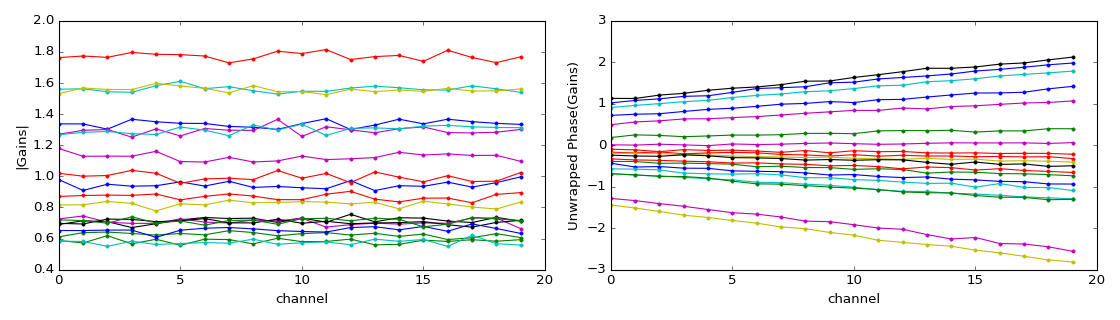

In [65]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(np.abs(allGainSols),'.-');
plt.xlabel('channel'); plt.ylabel('|Gains|')

plt.subplot(122)
plt.plot(np.unwrap(np.angle(allGainSols).T).T,'.-');
plt.xlabel('channel'); plt.ylabel('Unwrapped Phase(Gains)');

plt.tight_layout()